# Normalization PREP with ANT (Registration function)

In [12]:
import os
from os.path import join as opj
from nipype.interfaces.ants import Registration
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node
from nipype.interfaces.fsl import Info

In [13]:
experiment_dir = '/data/wellbeing_analysis'
output_dir = 'datasink'
working_dir = 'workingdir'

#subject list
subject_list = os.listdir("/data/wellbeing_bids")
subject_list.remove('dataset_description.json')

subject_list = [sub[-4:] for sub in subject_list]

# list of session identifiers
task_list = ['empathy']

template = '/home/zohyos7/fmri/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

In [14]:
subject_list_done_reg = os.listdir("/data/wellbeing_analysis/datasink/antsreg")
subject_list_done_reg = [sub[-4:] for sub in subject_list_done_reg]
subject_list_done_reg

full_subject_list = os.listdir("/data/wellbeing_bids")
full_subject_list.remove('dataset_description.json')
full_subject_list = [sub[-4:] for sub in full_subject_list]
full_subject_list.sort()

In [ ]:
subject_list = list(set(full_subject_list)^set(subject_list_done_reg))

In [16]:
antsreg = Node(Registration(args='--float',
                            collapse_output_transforms=True,
                            fixed_image=template,
                            initial_moving_transform_com=True,
                            num_threads=4,
                            output_inverse_warped_image=True,
                            output_warped_image=True,
                            sigma_units=['vox'] * 3,
                            transforms=['Rigid', 'Affine', 'SyN'],
                            terminal_output='file',
                            winsorize_lower_quantile=0.005,
                            winsorize_upper_quantile=0.995,
                            convergence_threshold=[1e-06],
                            convergence_window_size=[10],
                            metric=['MI', 'MI', 'CC'],
                            metric_weight=[1.0] * 3,
                            number_of_iterations=[[1000, 500, 250, 100],
                                                  [1000, 500, 250, 100],
                                                  [100, 70, 50, 20]],
                            radius_or_number_of_bins=[32, 32, 4],
                            sampling_percentage=[0.25, 0.25, 1],
                            sampling_strategy=['Regular', 'Regular', 'None'],
                            shrink_factors=[[8, 4, 2, 1]] * 3,
                            smoothing_sigmas=[[3, 2, 1, 0]] * 3,
                            transform_parameters=[(0.1,), (0.1,),
                                                  (0.1, 3.0, 0.0)],
                            use_histogram_matching=True,
                            write_composite_transform=True),
               name='antsreg')

In [17]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]

# SelectFiles - to grab the data (alternative to DataGrabber)
anat_file = opj('sub-{subject_id}', 'anat', 'sub-{subject_id}_T1w.nii.gz')
templates = {'anat': anat_file}

selectfiles = Node(SelectFiles(templates,
                               base_directory='/data/wellbeing_bids'),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
datasink.inputs.substitutions = substitutions

###
# Specify Normalization Workflow & Connect Nodes

# Initiation of the ANTS normalization workflow
regflow = Workflow(name='regflow')
regflow.base_dir = opj(experiment_dir, working_dir)

# Connect workflow nodes
regflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                 (selectfiles, antsreg, [('anat', 'moving_image')]),
                 (antsreg, datasink, [('warped_image',
                                       'antsreg.@warped_image'),
                                      ('inverse_warped_image',
                                       'antsreg.@inverse_warped_image'),
                                      ('composite_transform',
                                       'antsreg.@transform'),
                                      ('inverse_composite_transform',
                                       'antsreg.@inverse_transform')]),
                 ])

In [18]:
# Run Workflow
regflow.write_graph(graph2use='colored', format ='png', simple_form=True)

180917-19:00:07,754 nipype.workflow INFO:
	 Generated workflow graph: /data/wellbeing_analysis/workingdir/regflow/graph.png (graph2use=colored, simple_form=True).


'/data/wellbeing_analysis/workingdir/regflow/graph.png'

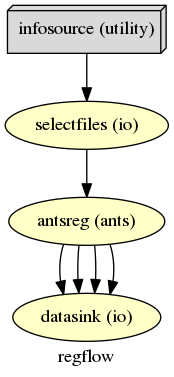

In [19]:
from IPython.display import Image
Image(filename= '/data/wellbeing_analysis/workingdir/regflow/graph.png')

In [ ]:
regflow.run('MultiProc', plugin_args={'n_procs':15})